### ΕΙΣΑΓΩΓΗ ΒΙΒΛΙΟΘΗΚΗΣ PYSTRATA ΚΑΙ ΛΟΙΠΩΝ ΒΙΒΛΙΟΘΗΚΩΝ PYTHON

In [1]:
import pystrata

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pystrata.motion import TimeSeriesMotion

### ΣΥΝΑΡΤΗΣΗ ΕΙΣΑΓΩΓΗΣ ΔΙΕΓΕΡΣΗΣ ΑΠΟ txt ΑΡΧΕΙΟ 

In [4]:
def time_accel_txt_to_pystrata_motion(filename: str) -> TimeSeriesMotion:
    df = pd.read_csv(filename, header=None, skiprows=2, encoding = "utf-8", delim_whitespace=True)
    accels = df[1].to_numpy()
    time_step = df[0][1] - df[0][0]

    return TimeSeriesMotion(filename=filename, description='', time_step=time_step, accels=accels)

### ΕΙΣΑΓΩΓΗ ΑΡΧΕΙΟΥ 

In [5]:
ts =  time_accel_txt_to_pystrata_motion('ChiChi.txt')

In [6]:
ts.accels

array([9.034156e-06, 9.026870e-06, 9.016792e-06, ..., 2.630041e-04,
       2.612812e-04, 2.595061e-04])

In [7]:
print(ts.time_step)

0.004999999999999999


In [8]:
# Increased figure sizes
plt.rcParams["figure.dpi"] =120

### ΑΠΕΙΚΟΝΙΣΗ ΓΡΑΦΗΜΑΤΟΣ ΕΠΙΤΑΧΥΝΣΙΟΓΡΑΦΗΜΑΤΟΣ 

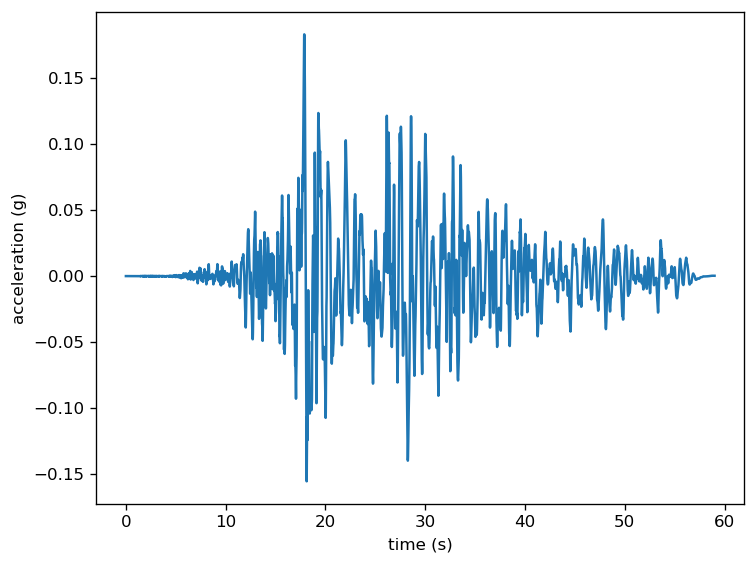

In [9]:
fig, ax = plt.subplots()
ax.plot(ts.times, ts.accels)
ax.set(xlabel='time (s)', ylabel='acceleration (g)')
fig.tight_layout()

### ΕΙΣΑΓΩΓΗ ΕΔΑΦΙΚΩΝ ΣΤΡΩΣΕΩΝ 

In [10]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.KishidaSoilType(unit_wt=16.0, stress_vert=40, organic_content=5, lab_consol_ratio=1),
            5,
            140,
        ),
        pystrata.site.Layer(
            pystrata.site.KishidaSoilType(unit_wt=18.0, stress_vert=215, organic_content=2, lab_consol_ratio=1),
            15,
            250,
        ),
        pystrata.site.Layer(
            pystrata.site.KishidaSoilType(unit_wt=20.0, stress_vert=650, organic_content=0, lab_consol_ratio=1),
            30,
            450,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 23.0, None, 0.02), 0, 1200),
    ]
).auto_discretize()

### ΓΡΑΦΗΜΑ ΒΑΘΟΥΣ-ΤΑΧΥΤΗΤΑΣ ΔΙΑΤΜΗΤΙΚΩΝ ΚΥΜΑΤΩΝ

<AxesSubplot:xlabel='Initial $V_s$ (m/s)', ylabel='Depth (m)'>

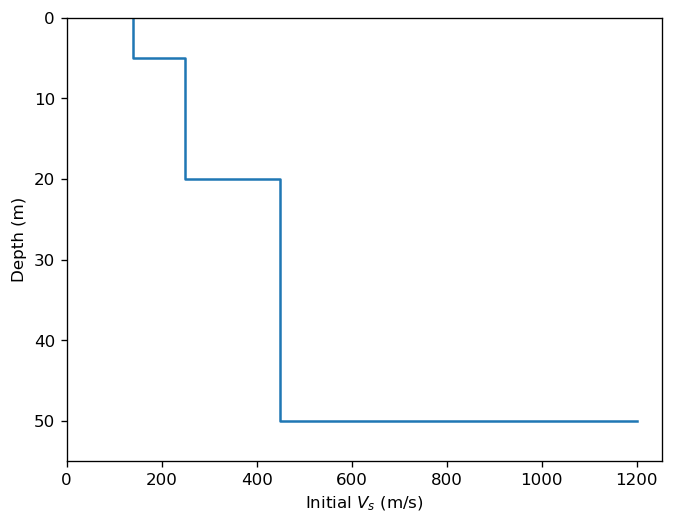

In [11]:
profile.plot("initial_shear_vel")

### ΟΡΙΣΜΟΣ ΜΕΘΟΔΟΥ ΑΝΑΛΥΣΗΣ

In [12]:
calcs = [
    pystrata.propagation.EquivalentLinearCalculator()
]

### ΟΡΙΣΜΟΣ ΕΞΑΓΟΜΕΝΩΝ 

In [13]:
freqs = np.logspace(-1, 2, num=113)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ), 
        pystrata.output.AccelTransferFunctionOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
        ),
       
    ]
)

In [14]:
motion = pystrata.motion.TimeSeriesMotion('ChiChi.txt', description='', time_step=ts.time_step, accels=ts.accels)

### ΥΠΟΛΟΓΙΣΜΟΙ ΜΕΘΟΔΟΥ ΑΝΑΛΥΣΗΣ 

In [15]:
for c in calcs:
    c(motion, profile, profile.location("outcrop", index=-1))
    outputs(c, f"{c.strain_limit:0.2f}")

### ΕΚΤΥΠΩΣΗ ΓΡΑΦΗΜΑΤΩΝ

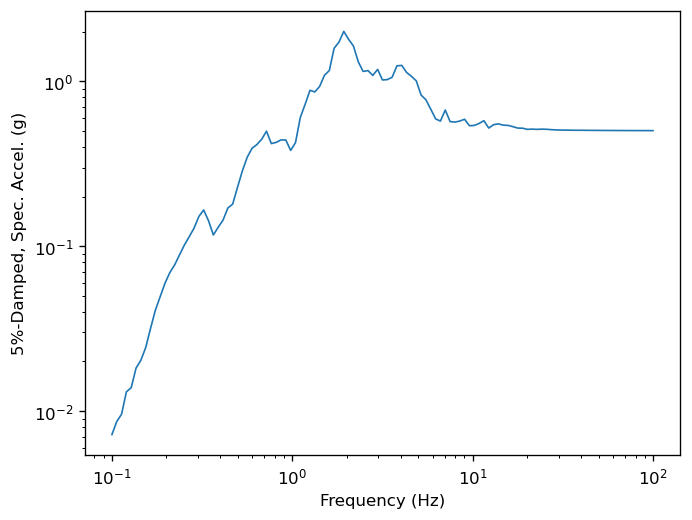

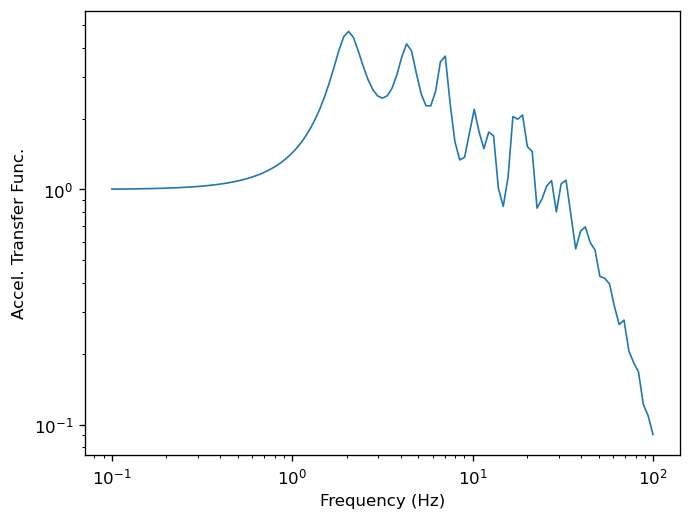

In [16]:
for o in outputs[:2]:
    ax = o.plot(style="indiv")
    

In [17]:
df = outputs[0].to_dataframe()
df

,0.05
0.100000,0.007189
0.106362,0.008624
0.113128,0.009562
0.120325,0.013070
0.127980,0.013855
...,...
78.137074,0.503063
83.108005,0.502965
88.395177,0.502877
94.018709,0.502800


In [18]:
df = outputs[1].to_dataframe()
df

,0.05
0.100000,1.002957
0.106362,1.003377
0.113128,1.003851
0.120325,1.004386
0.127980,1.005005
...,...
78.137074,0.183351
83.108005,0.167536
88.395177,0.121967
94.018709,0.109036


### ΕΞΑΓΩΓΗ ΔΕΔΟΜΕΝΩΝ ΣΕ ΑΡΧΕΙΟ .xls

In [19]:
df = outputs[0].to_dataframe()
df.to_excel('KISHIDA ChiChi.xlsx', index=True)